In [1]:
import os
import json
import pandas as pd

In [2]:
def parse_json_file(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data


def extract_data(json_data, model_name):
    records = []
    for dataset, metrics in json_data.items():
        for metric_name, values in metrics.items():
            if metric_name.startswith("mmlu_"):
                continue
            elif dataset == "glue" and metric_name != "glue":
                continue
            elif (
                dataset == "super-glue-lm-eval-v1"
                and metric_name != "super-glue-lm-eval-v1"
            ):
                continue
            elif dataset == "lambada" and metric_name != "lambada":
                continue
            record = {
                "model": model_name,
                "dataset": metric_name,
            }
            for key, value in values.items():
                if key in [
                    "acc,none",
                    "exact_match,strict-match",
                    "f1,none",
                    "mcc,none",
                    "em,none",
                    "perplexity,none",
                ]:
                    record[key] = value
            records.append(record)
    return records


def extract_model_info(filename):
    parts = filename.split(".")
    model_name = "".join(parts[:-1])
    return model_name


def load_data_from_directory(directory):
    all_records = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".json"):
            model_name = extract_model_info(file_name)
            file_path = os.path.join(directory, file_name)
            json_data = parse_json_file(file_path)
            records = extract_data(json_data, model_name)
            all_records.extend(records)
    return pd.DataFrame(all_records)

In [3]:
directory_path = "ft_eval_results"

df = load_data_from_directory(directory_path)

df["model"] = df["model"].str.replace("llama3_8b_", "", case=False, regex=True)
df["model"] = df["model"].str.replace("_", " ", case=False, regex=False)
df["model"] = df["model"].str.capitalize()

In [4]:
baseline_path = "baseline_eval_results"

baseline_df = load_data_from_directory(baseline_path)

baseline_df["model"] = baseline_df["model"].str.replace(
    "results_llama_8b_", "", case=False, regex=True
)
baseline_df["model"] = baseline_df["model"].str.replace(
    "_limit_100", "", case=False, regex=True
)
baseline_df["model"] = baseline_df["model"].str.replace(
    "_", " ", case=False, regex=False
)
baseline_df["model"] = baseline_df["model"].str.capitalize()

baseline_df = baseline_df[baseline_df["model"].str.contains("nf4")]

In [5]:
baseline_df.head(10)

,model,dataset,"acc,none","exact_match,strict-match","f1,none","mcc,none","em,none","perplexity,none"
40,Pretrained nf4,arc_challenge,0.540000,NaN,NaN,NaN,NaN,NaN
41,Pretrained nf4,hellaswag,0.530000,NaN,NaN,NaN,NaN,NaN
42,Pretrained nf4,truthfulqa_mc1,0.280000,NaN,NaN,NaN,NaN,NaN
43,Pretrained nf4,winogrande,0.780000,NaN,NaN,NaN,NaN,NaN
44,Pretrained nf4,gsm8k,NaN,0.45,NaN,NaN,NaN,NaN
45,Pretrained nf4,mmlu,0.640000,NaN,NaN,NaN,NaN,NaN
46,Pretrained nf4,glue,0.629053,NaN,0.588678,0.233664,NaN,NaN
47,Pretrained nf4,super-glue-lm-eval-v1,0.669207,NaN,0.785868,NaN,0.93,NaN
48,Pretrained nf4,lambada,0.660000,NaN,NaN,NaN,NaN,4.108983
49,Pretrained nf4,prost,0.400000,NaN,NaN,NaN,NaN,NaN


In [6]:
df = pd.concat([df, baseline_df])
df["model"] = df["model"].str.replace("Moe", "MoE", case=False, regex=True)

In [8]:
df_melted = df.melt(id_vars=["model", "dataset"], var_name="metric", value_name="value")

df_melted = df_melted.dropna(subset=["value"])
df_melted = df_melted[df_melted["dataset"] != "lambada"]
df_melted["metric"] = df_melted["metric"].str.replace(
    ",none", "", case=False, regex=True
)

metric_name_map = {
    "acc": "Accuracy",
    "f1": "F1",
    "mcc": "MCC",
    "em": "Exact match",
    "exact_match,strict-match": "Exact match",
}

df_melted["metric"] = df_melted["metric"].map(metric_name_map)

dataset_name_map = {
    "arc_challenge": "ARC Challenge",
    "glue": "GLUE",
    "gsm8k": "GSM8K",
    "hellaswag": "Hellaswag",
    "mmlu": "MMLU",
    "prost": "PROST",
    "super-glue-lm-eval-v1": "SuperGLUE",
    "truthfulqa_mc1": "TruthfulQA",
    "winogrande": "Winogrande",
}

df_melted["dataset"] = df_melted["dataset"].map(dataset_name_map)

df_melted["value"] = df_melted["value"].round(4)

result_df = df_melted.pivot_table(
    index=["dataset", "metric"], columns="model", values="value", aggfunc="first"
)

result_df = result_df.sort_index(level=0)

result_df.to_csv("ft_eval_results/ft_eval_results.csv")
result_df

model                      Instruct customer  Instruct mixed  Instruct nf4  \
dataset       metric                                                         
ARC Challenge Accuracy                0.5300          0.5100        0.5400   
GLUE          Accuracy                0.7471          0.6291        0.7419   
              F1                      0.7184          0.7544        0.7185   
              MCC                     0.3091          0.3012        0.4271   
GSM8K         Exact match             0.5400          0.6300        0.7100   
Hellaswag     Accuracy                0.5700          0.5700        0.5200   
MMLU          Accuracy                0.6139          0.6328        0.6509   
PROST         Accuracy                0.5800          0.5600        0.6300   
SuperGLUE     Accuracy                0.6814          0.6326        0.6707   
              Exact match             0.9000          0.8900        0.9000   
              F1                      0.8184          0.6894        0.8539   
TruthfulQA    Accuracy                0.3500          0.3200        0.3400   
Winogrande    Accuracy                0.8300          0.8100        0.8100   

model                      MoE instruct customer  MoE instruct mixed  \
dataset       metric                                                   
ARC Challenge Accuracy                    0.5300              0.5400   
GLUE          Accuracy                    0.7328              0.5863   
              F1                          0.6875              0.7307   
              MCC                         0.3048              0.1147   
GSM8K         Exact match                 0.5200              0.5000   
Hellaswag     Accuracy                    0.5700              0.5500   
MMLU          Accuracy                    0.6126              0.6423   
PROST         Accuracy                    0.6200              0.5200   
SuperGLUE     Accuracy                    0.6784              0.6082   
              Exact match                 0.9300              0.9000   
              F1                          0.8750              0.6579   
TruthfulQA    Accuracy                    0.3800              0.3300   
Winogrande    Accuracy                    0.8000              0.7900   

model                      MoE pretrained customer  MoE pretrained mixed  \
dataset       metric                                                       
ARC Challenge Accuracy                      0.5600                0.5400   
GLUE          Accuracy                      0.6680                0.6719   
              F1                            0.4719                0.7517   
              MCC                           0.2054                0.2478   
GSM8K         Exact match                   0.4500                0.3500   
Hellaswag     Accuracy                      0.5500                0.5500   
MMLU          Accuracy                      0.6251                0.6126   
PROST         Accuracy                      0.2700                0.4300   
SuperGLUE     Accuracy                      0.6784                0.6616   
              Exact match                   0.9300                0.9100   
              F1                            0.8049                0.7887   
TruthfulQA    Accuracy                      0.3500                0.3100   
Winogrande    Accuracy                      0.7600                0.7800   

model                      Pretrained customer  Pretrained mixed  \
dataset       metric                                               
ARC Challenge Accuracy                  0.5600            0.5600   
GLUE          Accuracy                  0.6563            0.6342   
              F1                        0.4542            0.7476   
              MCC                       0.2296            0.2978   
GSM8K         Exact match               0.3700            0.5000   
Hellaswag     Accuracy                  0.5500            0.5600   
MMLU          Accuracy                  0.6288            0.622

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_dataset(df, dataset_name):
    dataset_df = df[df["dataset"] == dataset_name]

    pretrained_df = dataset_df[
        dataset_df["model"].str.contains("Pretrained", case=False)
    ]
    pretrained_df["model"] = pretrained_df["model"].str.replace(
        "Pretrained", "", case=False, regex=False
    )
    pretrained_df["model"] = pretrained_df["model"].str.strip()

    pretrained_df["model"] = pretrained_df["model"].replace("MoE  mixed", "MoE - mixed")
    pretrained_df["model"] = pretrained_df["model"].replace(
        "MoE  customer", "MoE - customer"
    )
    pretrained_df["model"] = pretrained_df["model"].replace("nf4", "Model bazowy w nf4")
    pretrained_df["model"] = pretrained_df["model"].replace(
        "customer", "Gęsty - customer"
    )
    pretrained_df["model"] = pretrained_df["model"].replace("mixed", "Gęsty - mixed")

    instruct_df = dataset_df[dataset_df["model"].str.contains("Instruct", case=False)]
    instruct_df["model"] = instruct_df["model"].str.replace(
        "Instruct", "", case=False, regex=False
    )
    instruct_df["model"] = instruct_df["model"].str.strip()
    instruct_df["model"] = instruct_df["model"].replace("MoE  mixed", "MoE - mixed")
    instruct_df["model"] = instruct_df["model"].replace(
        "MoE  customer", "MoE - customer"
    )
    instruct_df["model"] = instruct_df["model"].replace("nf4", "Model bazowy w nf4")
    instruct_df["model"] = instruct_df["model"].replace("customer", "Gęsty - customer")
    instruct_df["model"] = instruct_df["model"].replace("mixed", "Gęsty - mixed")

    def melt_and_plot(ax, subset_df, title_suffix):
        dataset_melted = subset_df.melt(
            id_vars=["model"],
            value_vars=[
                "acc,none",
                "exact_match,strict-match",
                "f1,none",
                "mcc,none",
                "em,none",
                "perplexity,none",
            ],
            var_name="metric",
            value_name="value",
        )

        dataset_melted["value"] = dataset_melted["value"].replace(0.0, None)
        dataset_melted = dataset_melted.dropna(subset=["value"])
        dataset_melted["metric"] = dataset_melted["metric"].apply(
            lambda x: x.split(",")[0]
        )

        sorted_models = [
            "Model bazowy w nf4",
            "Gęsty - customer",
            "MoE - customer",
            "Gęsty - mixed",
            "MoE - mixed",
        ]

        sns.barplot(
            ax=ax,
            x="model",
            y="value",
            hue="metric",
            data=dataset_melted,
            order=sorted_models,
            palette="Set2",
        )
        ax.set_title(f"Wyniki w {dataset_name} ({title_suffix})")
        ax.set_xlabel("")
        ax.set_ylabel("Wartość metryki")
        ax.tick_params(axis="x")
        ax.legend(title="Metryka", loc="upper right")

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True, sharex=False)

    melt_and_plot(axes[0], pretrained_df, "Modele Pretrained")

    melt_and_plot(axes[1], instruct_df, "Modele Instruct")

    plt.tight_layout()
    plt.show()


# Example usage
dataset_names = df["dataset"].unique()

                model metric  value
0       Gęsty - mixed    acc   0.56
1    Gęsty - customer    acc   0.56
2         MoE - mixed    acc   0.54
3      MoE - customer    acc   0.56
4  Model bazowy w nf4    acc   0.54
                model metric  value
0      MoE - customer    acc   0.53
1       Gęsty - mixed    acc   0.51
2    Gęsty - customer    acc   0.53
3         MoE - mixed    acc   0.54
4  Model bazowy w nf4    acc   0.54


/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

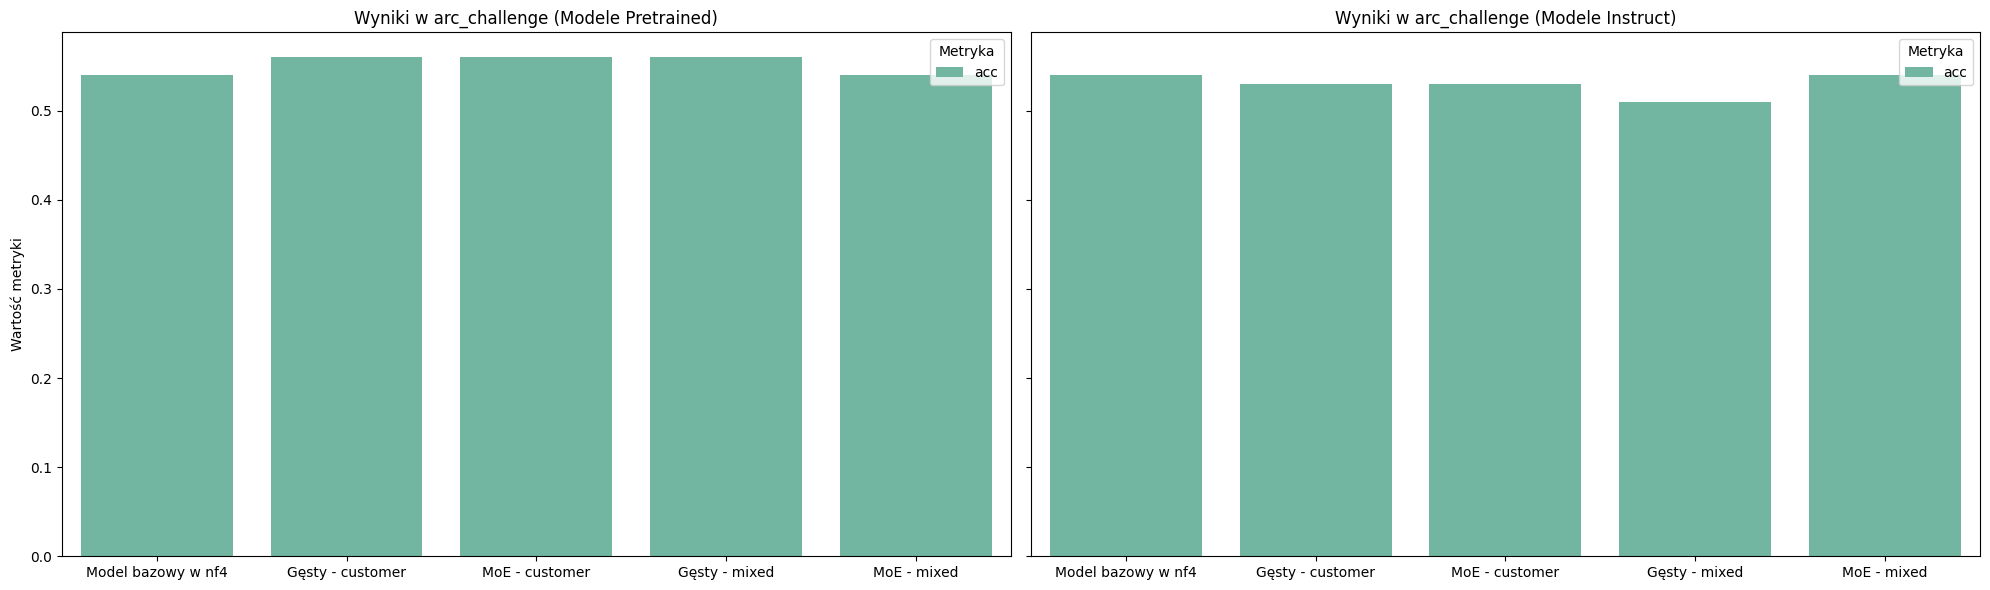

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                model metric  value
0       Gęsty - mixed    acc   0.56
1    Gęsty - customer    acc   0.55
2         MoE - mixed    acc   0.55
3      MoE - customer    acc   0.55
4  Model bazowy w nf4    acc   0.53
                model metric  value
0      MoE - customer    acc   0.57
1       Gęsty - mixed    acc   0.57
2    Gęsty - customer    acc   0.57
3         MoE - mixed    acc   0.55
4  Model bazowy w nf4    acc   0.52


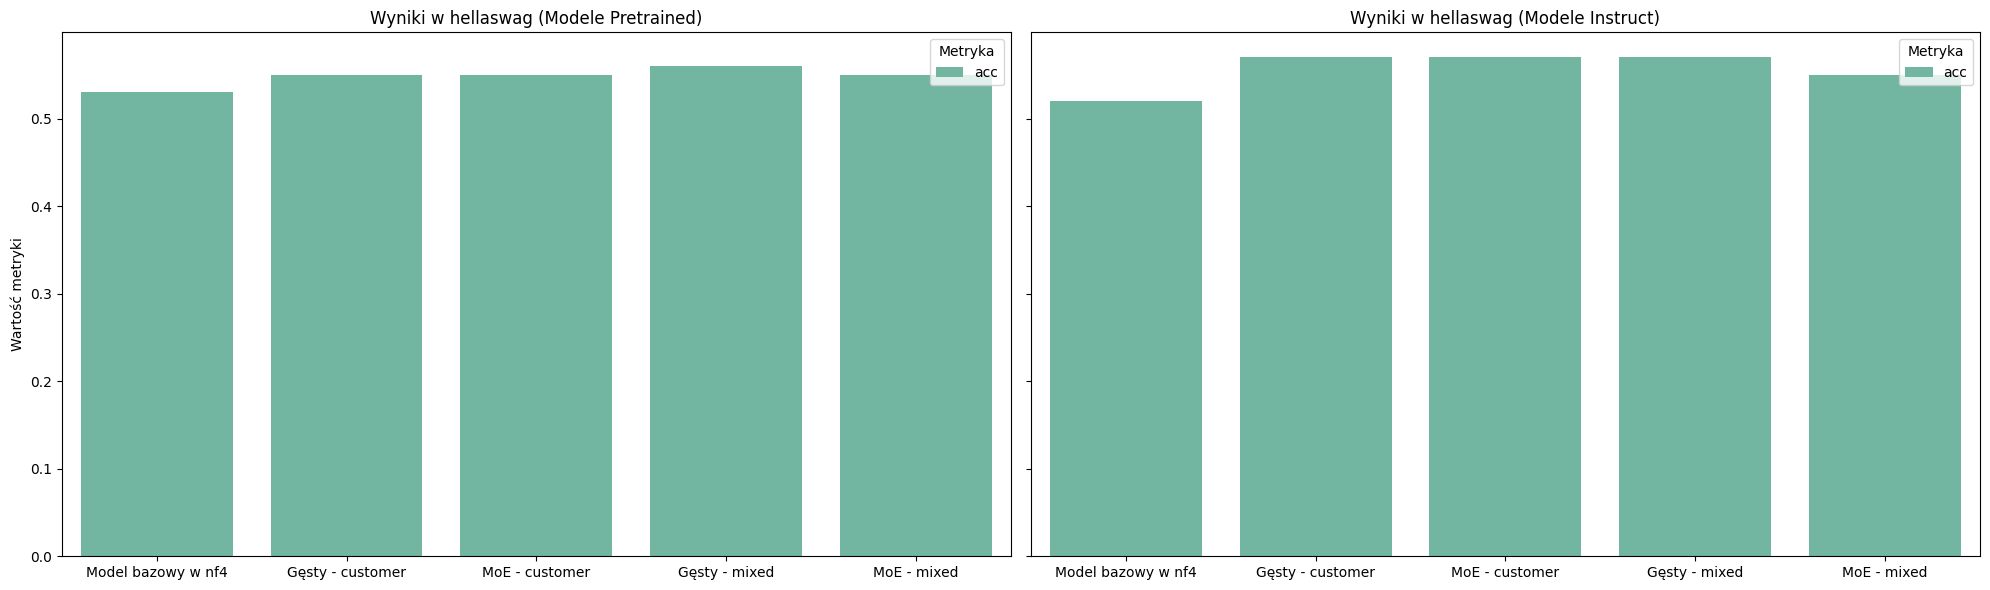

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                model metric  value
0       Gęsty - mixed    acc   0.32
1    Gęsty - customer    acc   0.36
2         MoE - mixed    acc   0.31
3      MoE - customer    acc   0.35
4  Model bazowy w nf4    acc   0.28
                model metric  value
0      MoE - customer    acc   0.38
1       Gęsty - mixed    acc   0.32
2    Gęsty - customer    acc   0.35
3         MoE - mixed    acc   0.33
4  Model bazowy w nf4    acc   0.34


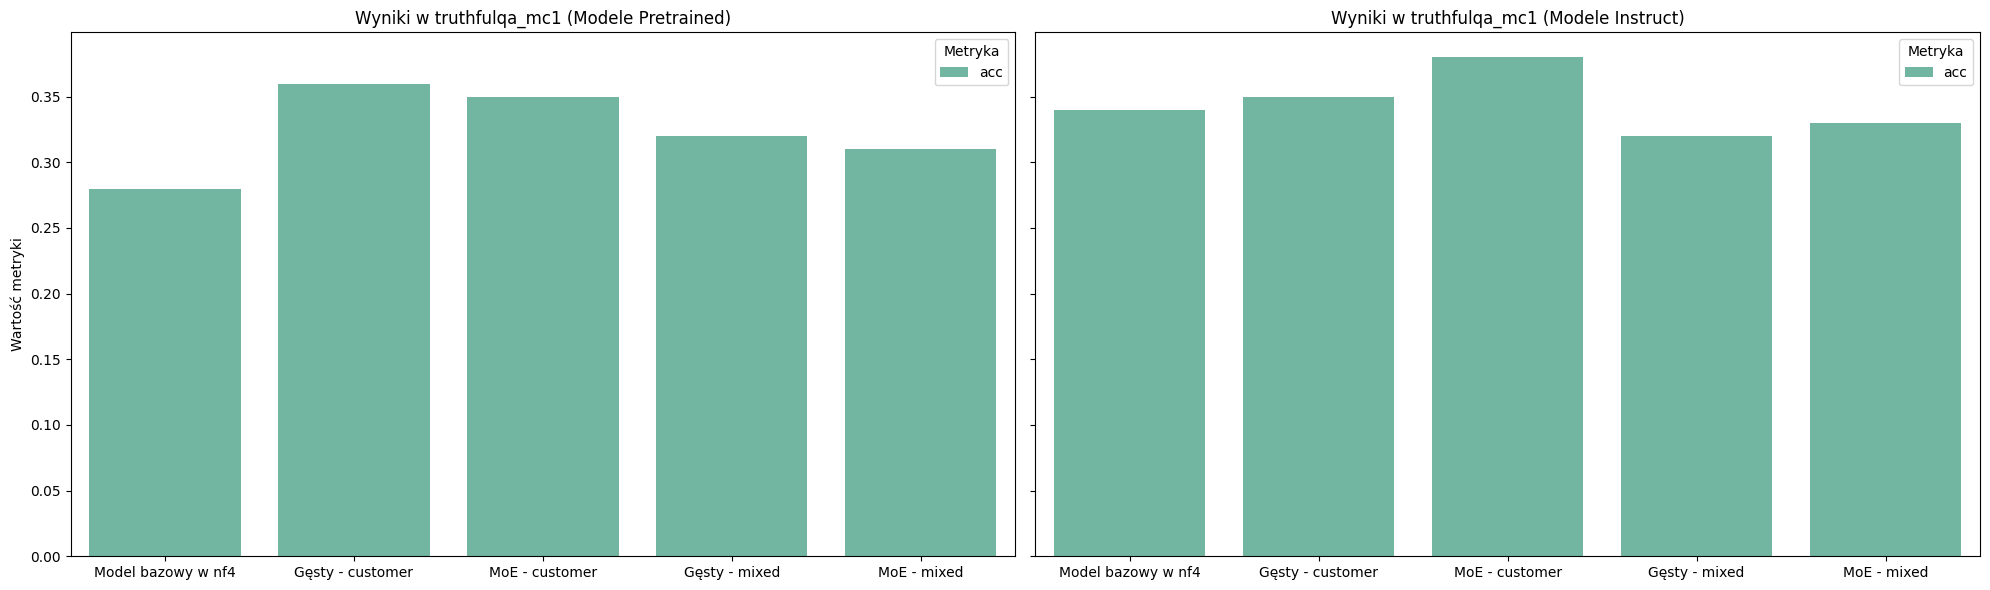

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                model metric  value
0       Gęsty - mixed    acc   0.82
1    Gęsty - customer    acc   0.76
2         MoE - mixed    acc   0.78
3      MoE - customer    acc   0.76
4  Model bazowy w nf4    acc   0.78
                model metric  value
0      MoE - customer    acc   0.80
1       Gęsty - mixed    acc   0.81
2    Gęsty - customer    acc   0.83
3         MoE - mixed    acc   0.79
4  Model bazowy w nf4    acc   0.81


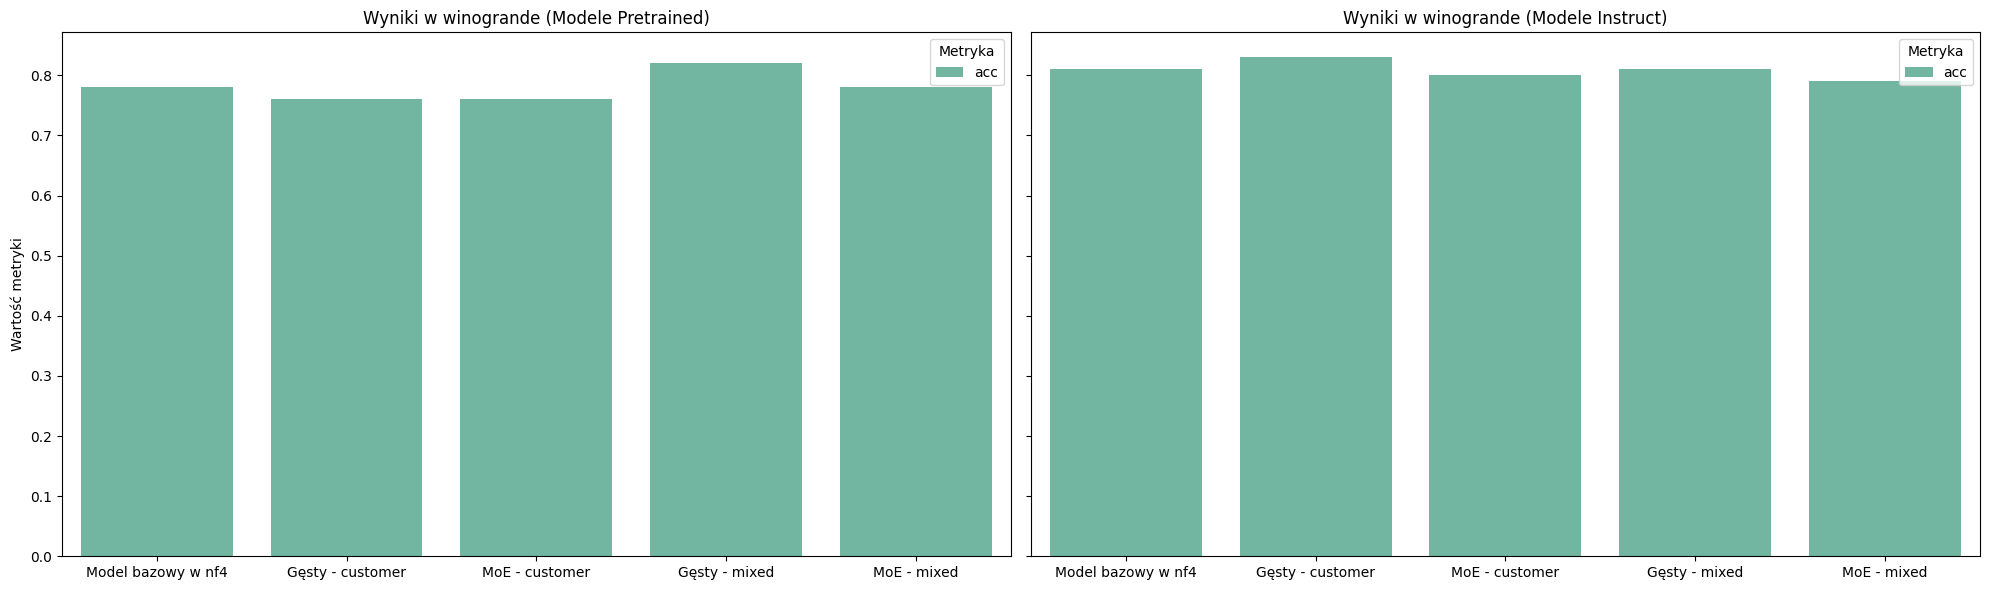

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                model       metric  value
5       Gęsty - mixed  exact_match   0.50
6    Gęsty - customer  exact_match   0.37
7         MoE - mixed  exact_match   0.35
8      MoE - customer  exact_match   0.45
9  Model bazowy w nf4  exact_match   0.45
                model       metric  value
5      MoE - customer  exact_match   0.52
6       Gęsty - mixed  exact_match   0.63
7    Gęsty - customer  exact_match   0.54
8         MoE - mixed  exact_match   0.50
9  Model bazowy w nf4  exact_match   0.71


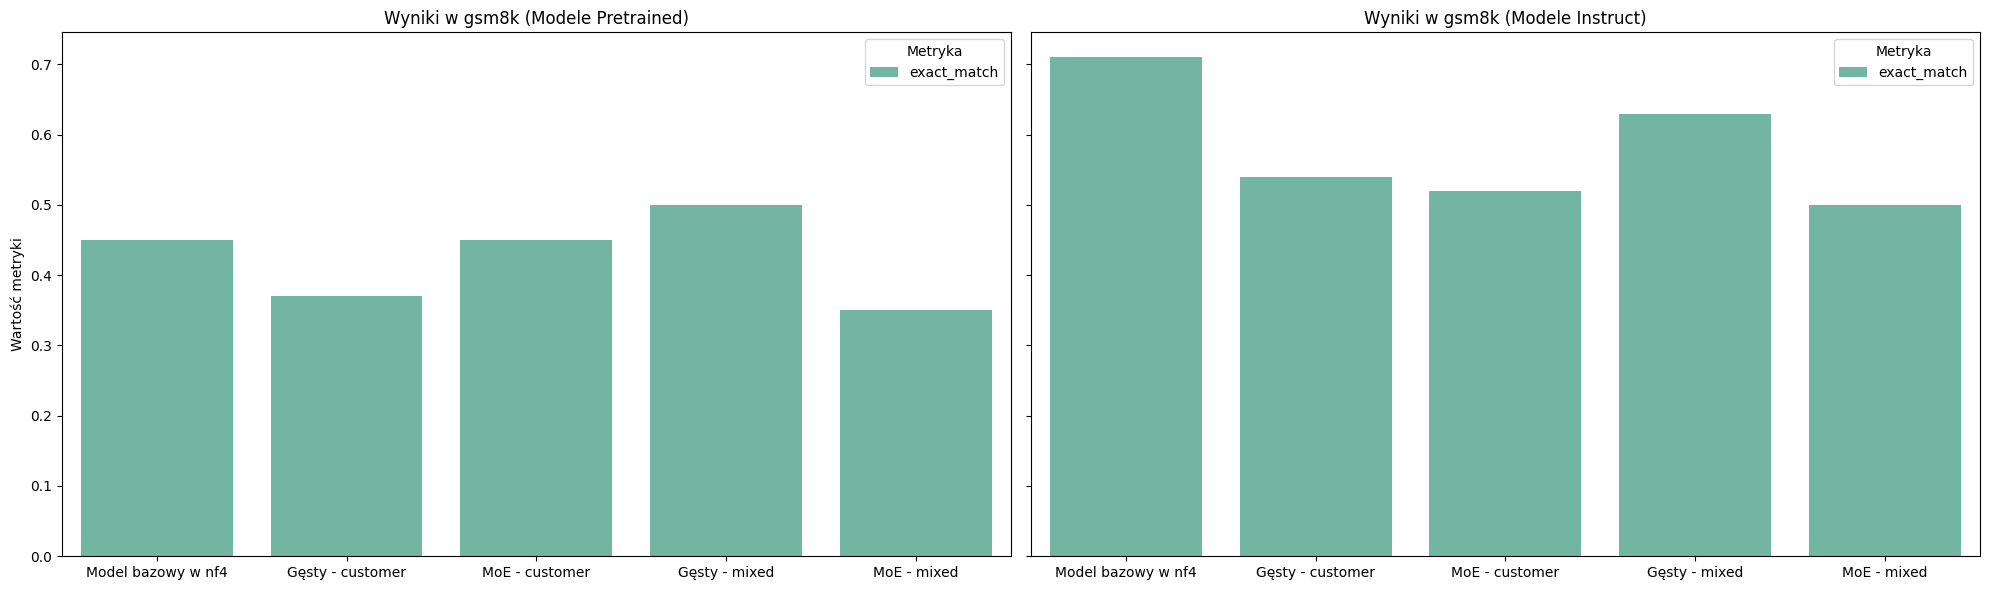

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                model metric     value
0       Gęsty - mixed    acc  0.622632
1    Gęsty - customer    acc  0.628772
2         MoE - mixed    acc  0.612632
3      MoE - customer    acc  0.625088
4  Model bazowy w nf4    acc  0.640000
                model metric     value
0      MoE - customer    acc  0.612632
1       Gęsty - mixed    acc  0.632807
2    Gęsty - customer    acc  0.613860
3         MoE - mixed    acc  0.642281
4  Model bazowy w nf4    acc  0.650877


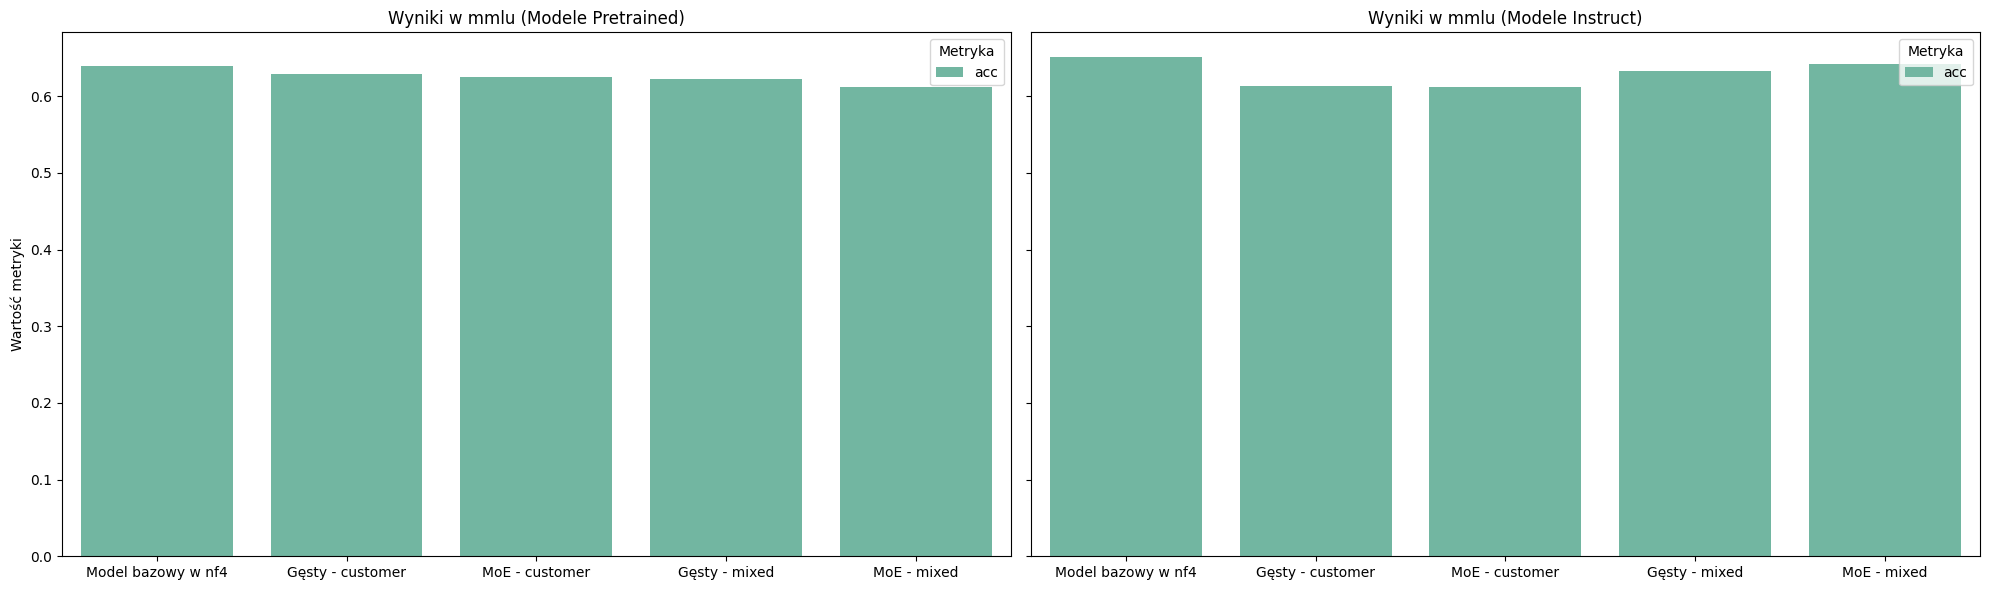

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                 model metric     value
0        Gęsty - mixed    acc  0.634241
1     Gęsty - customer    acc  0.656291
2          MoE - mixed    acc  0.671855
3       MoE - customer    acc  0.667964
4   Model bazowy w nf4    acc  0.629053
10       Gęsty - mixed     f1  0.747596
11    Gęsty - customer     f1  0.454204
12         MoE - mixed     f1  0.751705
13      MoE - customer     f1  0.471940
14  Model bazowy w nf4     f1  0.588678
15       Gęsty - mixed    mcc  0.297776
16    Gęsty - customer    mcc  0.229640
17         MoE - mixed    mcc  0.247770
18      MoE - customer    mcc  0.205370
19  Model bazowy w nf4    mcc  0.233664
                 model metric     value
0       MoE - customer    acc  0.732815
1        Gęsty - mixed    acc  0.629053
2     Gęsty - customer    acc  0.747082
3          MoE - mixed    acc  0.586252
4   Model bazowy w nf4    acc  0.741894
10      MoE - customer     f1  0.687484
11       Gęsty - mixed     f1  0.754386
12    Gęsty - customer     f1  0.718369


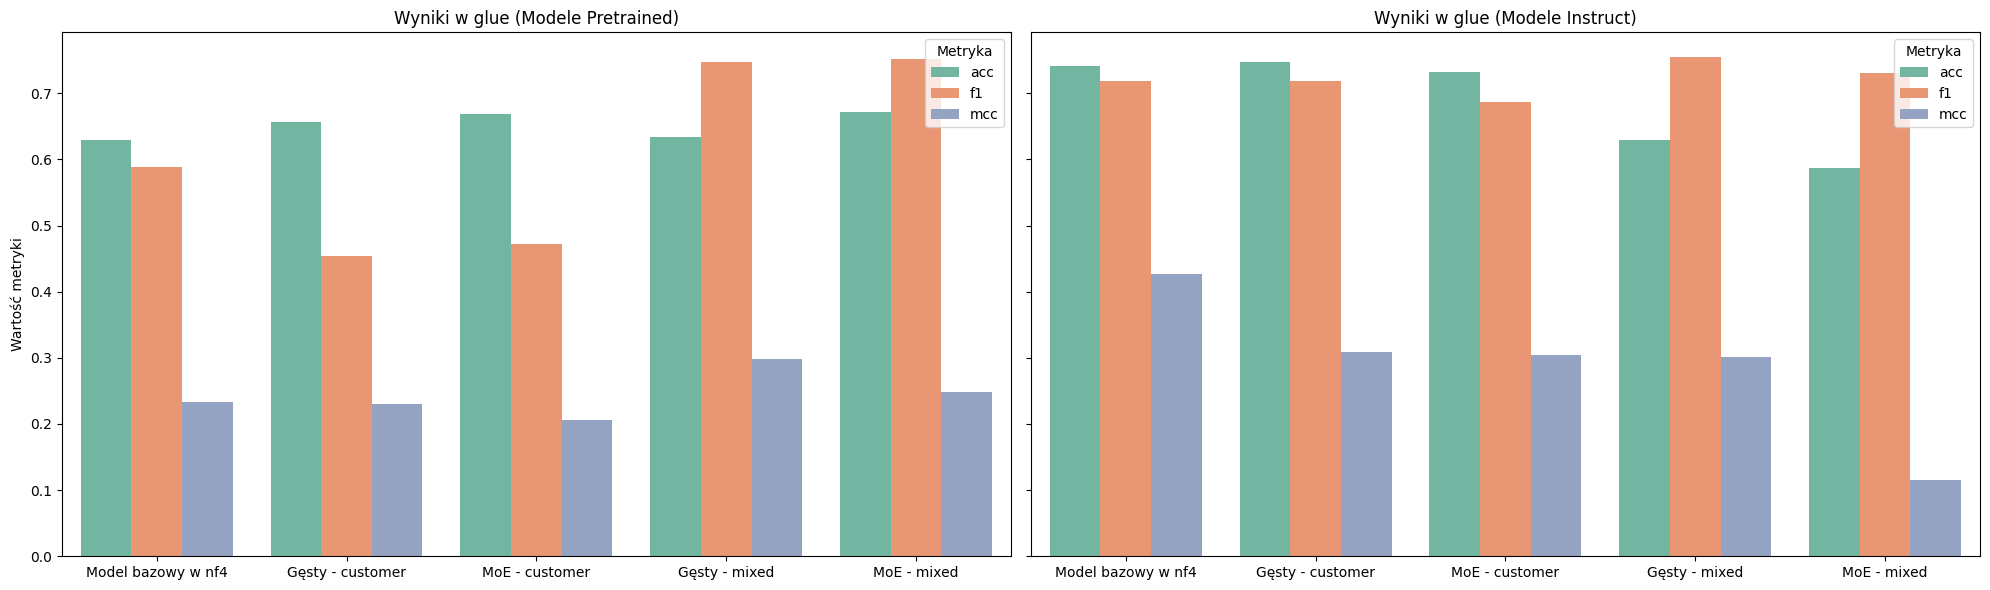

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                 model metric     value
0        Gęsty - mixed    acc  0.655488
1     Gęsty - customer    acc  0.678354
2          MoE - mixed    acc  0.661585
3       MoE - customer    acc  0.678354
4   Model bazowy w nf4    acc  0.669207
10       Gęsty - mixed     f1  0.767536
11    Gęsty - customer     f1  0.800189
12         MoE - mixed     f1  0.788713
13      MoE - customer     f1  0.804865
14  Model bazowy w nf4     f1  0.785868
20       Gęsty - mixed     em  0.920000
21    Gęsty - customer     em  0.920000
22         MoE - mixed     em  0.910000
23      MoE - customer     em  0.930000
24  Model bazowy w nf4     em  0.930000
                 model metric     value
0       MoE - customer    acc  0.678354
1        Gęsty - mixed    acc  0.632622
2     Gęsty - customer    acc  0.681402
3          MoE - mixed    acc  0.608232
4   Model bazowy w nf4    acc  0.670732
10      MoE - customer     f1  0.875018
11       Gęsty - mixed     f1  0.689399
12    Gęsty - customer     f1  0.818376


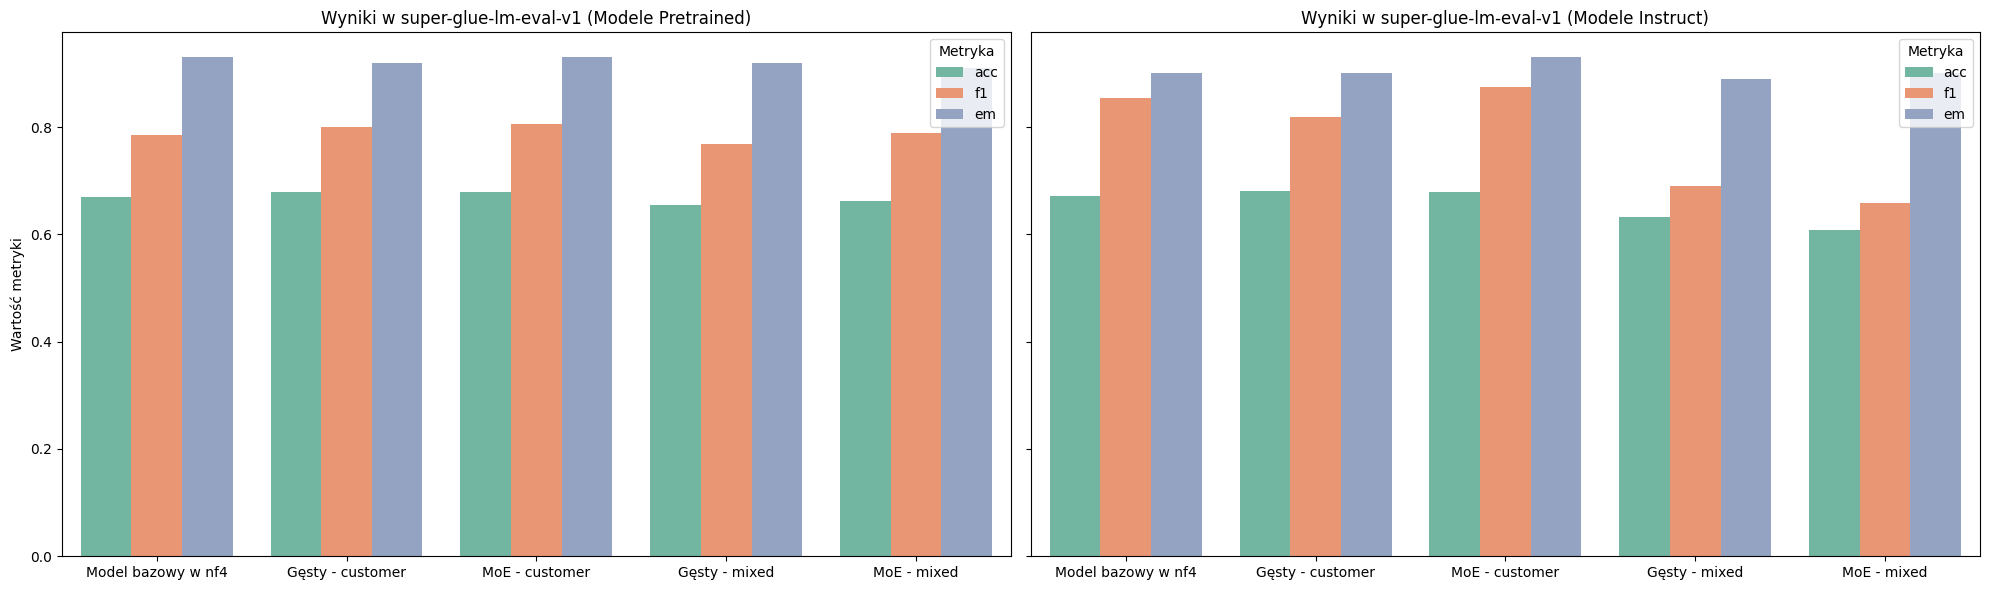

/tmp/ipykernel_222383/4228798201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_222383/4228798201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.strip()
/tmp/ipykernel_222383/4228798201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

                model metric  value
0       Gęsty - mixed    acc   0.26
1    Gęsty - customer    acc   0.28
2         MoE - mixed    acc   0.43
3      MoE - customer    acc   0.27
4  Model bazowy w nf4    acc   0.40
                model metric  value
0      MoE - customer    acc   0.62
1       Gęsty - mixed    acc   0.56
2    Gęsty - customer    acc   0.58
3         MoE - mixed    acc   0.52
4  Model bazowy w nf4    acc   0.63


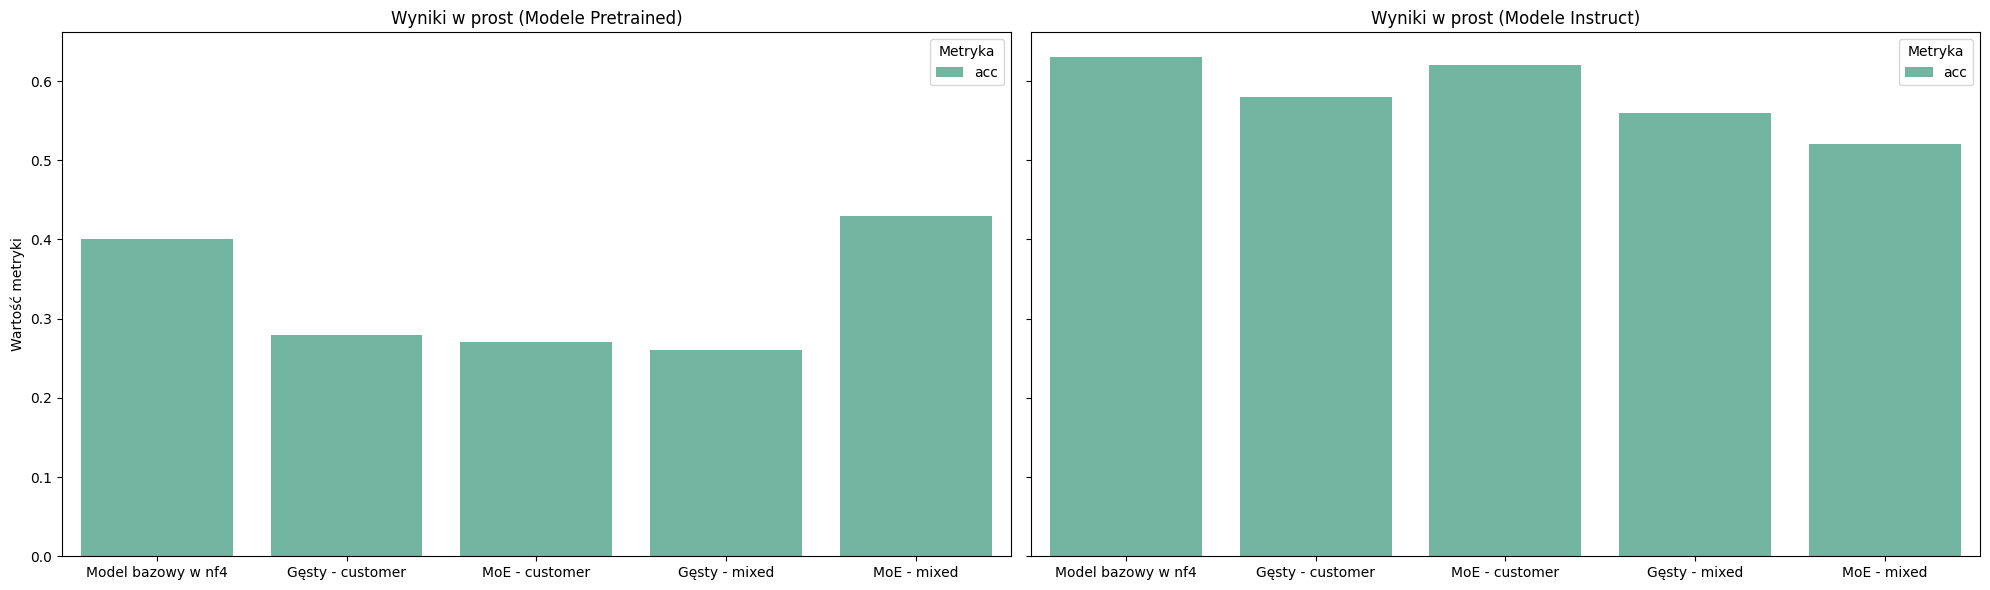

In [10]:
for dataset in dataset_names:
    if dataset != "lambada":
        plot_dataset(df, dataset)